# FGSM Imagenewoof Dataset Development

<div style="text-align: justify"> 
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
</div>

<div style="margin-top:20px">
$adv_x = x + \epsilon \times sign(\nabla_xJ(\theta, x, y))$, where:
</div>

- $adv_x$ : Adversarial image.
- $x$ : Original input image.
- $y$ : Original input label.
- $\epsilon$ : Multiplier to ensure the perturbations are small.
- $\theta$ : Model parameters.
- $J$ : Loss.

<div style="text-align: justify"> 
An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. <mark>The only goal is to fool an already trained model.</mark>
</div>

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [34]:
# TensorFlow
import tensorflow as tf

# CNN layers
from tensorflow.keras import layers, models

# Optimiziers
from tensorflow.keras.optimizers import Adam

# Others
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib.pyplot as mpl
import PIL
import PIL.Image
import pathlib
import pickle

print(tf.__version__)

2.15.0


In [3]:
# Plot configurations for later observations
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

### Loading Imagenewoof dataset

Loading the dataset we will get two `keras.utils` datasets:

- The `train_ds` corresponding to the training dataset.
- The `val_ds` corresponding to the validation dataset.

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |
| n02096294      | Australian terrier |
| n02099601      | Golden retriever |
| n02105641      | Old English sheepdog |
| n02111889      | Samoyed |
| n02115641      | Dingo |

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [15]:
dog_breeds = [
    'Shih-Tzu',
    'Rhodesian ridgeback',
    'Beagle',
    'English foxhound',
    'Border terrier'
]

# dog_breeds = [
#     'Shih-Tzu',
#     'Rhodesian ridgeback',
#     'Beagle',
#     'English foxhound',
#     'Border terrier',
#     'Australian terrier',
#     'Golden retriever',
#     'Old English sheepdog',
#     'Samoyed',
#     'Dingo'
# ]

In [16]:
dataset_train = "Datasets/Imagewoof/Train"
dataset_val = "Datasets/Imagewoof/Val"

dataset_train_dir = pathlib.Path(dataset_train).with_suffix('')
dataset_val_dir = pathlib.Path(dataset_val).with_suffix('')

In [17]:
batch_size = 32
img_height = 320
img_width = 320

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4344 files belonging to 5 classes.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1860 files belonging to 5 classes.


### Exploring the data

In [20]:
class_names = train_ds.class_names
print(class_names)

['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754']


In [21]:
# Change alpha-numeric classes to dog breed names
class_names = dog_breeds

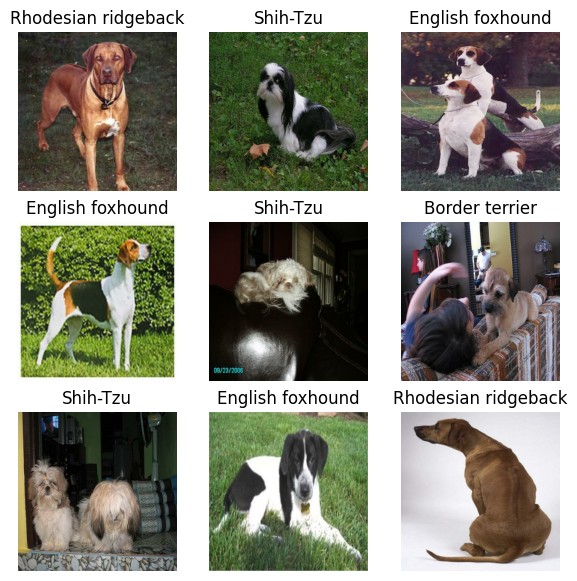

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 320, 320, 3)
(32,)


### Preprocess the data

The data must be preprocessed before training the network. If we inspect the first image in the training set, we will see that the pixel values fall in the range of 0 to 255:

In [ ]:
# Reshape the images to add the mono channel dimension (1)
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
# test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [24]:
for images, labels in train_ds.take(1):
    data_type = images[0].dtype
    max_value = tf.reduce_max(images[0]).numpy()
    
    if data_type == tf.uint8:
        print("[INFO] Images are in the range [0, 255]")
    elif data_type == tf.float32:
        if max_value <= 1.0:
            print("[INFO] Images are in the range [0, 1]")
        else:
            print("[INFO] Images are in the range [0, 255] (but represented as float32)")
    else:
        print("[INFO] Images might have a different data type or preprocessing")

[INFO] Images are in the range [0, 255] (but represented as float32)


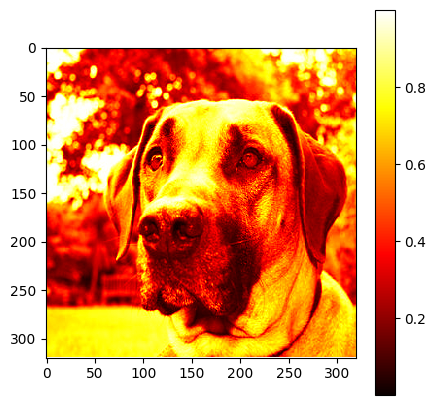

In [25]:
for images, labels in train_ds.take(1):
    images = images / 255.0
    gray_image = tf.image.rgb_to_grayscale(images[0])
    gray_image_np = gray_image.numpy()
    mpl.figure()
    mpl.imshow(gray_image_np[:, :, 0], cmap='hot', interpolation='nearest')
    mpl.colorbar()
    mpl.grid(False)
    mpl.show()

### Configure the dataset for performance

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model creation + training

In [28]:
# Define the CNN model
model = models.Sequential()

# Rescaling layer
model.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(len(class_names)))

In [29]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [31]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10
136/136 [==============================] - 381s 3s/step - loss: 2.0162 - accuracy: 0.3340 - val_loss: 1.4274 - val_accuracy: 0.3973
Epoch 2/10
136/136 [==============================] - 375s 3s/step - loss: 1.4040 - accuracy: 0.4164 - val_loss: 1.4026 - val_accuracy: 0.4124
Epoch 3/10
136/136 [==============================] - 328s 2s/step - loss: 1.2383 - accuracy: 0.4970 - val_loss: 1.3911 - val_accuracy: 0.4344
Epoch 4/10
136/136 [==============================] - 326s 2s/step - loss: 0.8691 - accuracy: 0.6752 - val_loss: 1.5205 - val_accuracy: 0.4113
Epoch 5/10
136/136 [==============================] - 317s 2s/step - loss: 0.5198 - accuracy: 0.8237 - val_loss: 1.7808 - val_accuracy: 0.3968
Epoch 6/10
136/136 [==============================] - 340s 3s/step - loss: 0.3507 - accuracy: 0.8877 - val_loss: 2.4742 - val_accuracy: 0.3586
Epoch 7/10
136/136 [==============================] - 347s 3s/step - loss: 0.2574 - accuracy: 0.9224 - val_loss: 2.9016 - val_accuracy: 0.3554

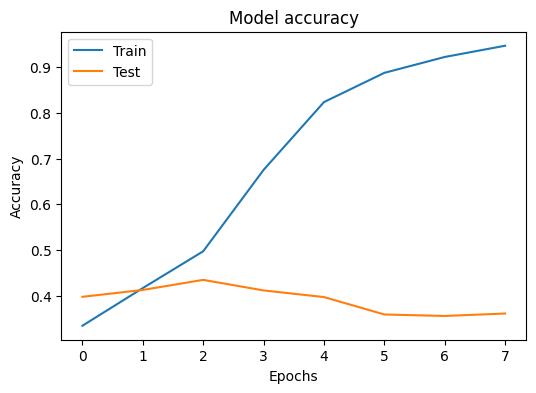

In [32]:
# Plot training & validation accuracy values
mpl.figure(figsize=(6,4))
mpl.plot(history.history['accuracy'])
mpl.plot(history.history['val_accuracy'])
mpl.title('Model accuracy')
mpl.ylabel('Accuracy')
mpl.xlabel('Epochs')
mpl.legend(['Train', 'Test'], loc='upper left')
mpl.show()

### Save the model and history

In [35]:
MODEL_TRAINED = "./Models/Imagenewoof-Normal.keras"
model.save(MODEL_TRAINED)

with open('./Models/Imagenewoof-History', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

### Load pretrained model and history

In [ ]:
MODEL_TRAINED = "./Models/Imagenewoof-Normal.keras"
model = tf.keras.models.load_model(MODEL_TRAINED)

with open('./Models/Imagenewoof-History', "rb") as file_pi:
    history = pickle.load(file_pi)

### Test accuracy and predictions

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

In [ ]:
np.argmax(predictions[0])

In [ ]:
test_labels[0]

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    mpl.grid(False)
    mpl.xticks([])
    mpl.yticks([])
    
    mpl.imshow(img, cmap=mpl.cm.binary)
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    mpl.xlabel("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100*np.max(predictions_array),
        class_names[true_label]),
        color=color
    )

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    mpl.grid(False)
    mpl.xticks(range(10))
    mpl.yticks([])
    
    thisplot = mpl.bar(range(10), predictions_array, color="#777777")
    mpl.ylim([0, 1])
    
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
i = 0
mpl.figure(figsize=(6,3))
mpl.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
mpl.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
mpl.show()

In [ ]:
i = 12
mpl.figure(figsize=(6,3))
mpl.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
mpl.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
mpl.show()

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
mpl.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    mpl.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    mpl.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
mpl.tight_layout()
mpl.savefig('Figures/Predictions-Normal/PredictionsFashionMNIST.png', bbox_inches='tight')
mpl.show()

### Creating the adversarial image pattern

The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, noise_factor=0.2):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    signed_grad = tf.image.resize(signed_grad, (28, 28))

    # Add more noise to the adversarial pattern
    noisy_signed_grad = signed_grad + noise_factor * tf.random.normal(tf.shape(signed_grad))

    return noisy_signed_grad

In [ ]:
def fgsm_attack(image_index):
    # Choose image and label with the model prediction
    image = (np.expand_dims(train_images[image_index], 0))
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image_probs = probability_model.predict(image, verbose=0)
    
    label = train_labels[image_index]
    label = tf.one_hot(image_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    # Create the perturbation pattern
    perturbations = create_adversarial_pattern(image, label)
    # mpl.imshow(perturbations[0] * 0.5 + 0.5) # Uncommnet for debug purposes, i.e, visualise the perturbation

    return (image, perturbations)

In [ ]:
def get_stats(image):
    image = (np.expand_dims(image, 0))
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image_probs = probability_model.predict(image, verbose=0)
    label = class_names[np.argmax(image_probs)]
    confidence = 100*np.max(image_probs)
    return (label, confidence, np.argmax(image_probs))

In [ ]:
def display_images(image, description, label, confidence, image_index, adv_label_num):
    mpl.figure()
    mpl.imshow(image[0]*0.5+0.5, cmap='gray')
    mpl.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence))
    mpl.savefig(f"Figures/FGSMDataset-Epsilon0160-PNGs/{image_index:05}_{adv_label_num}.png", bbox_inches='tight')
    # mpl.show() # Uncommnet for debug purposes, i.e, visualise the different levels of perturbations
    mpl.close()

### Using the pattern to create an adversarial image 

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15, 0.2]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

id = 0
image_index = 3
image, perturbations = fgsm_attack(image_index)

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    id+=1
    label, confidence, _ = get_stats(adv_x[0])
    display_images(adv_x, descriptions[i], label, confidence, image_index, _)

### Using the adversarial pattern to create the dataset

Following multiple tests and result analyses, the decision was made to generate the dataset with the corresponding $\epsilon$ set to 0.1.

In [ ]:
epsilon = 0.16
# epsilon = 0.1

description = 'Epsilon = {:0.3f}'.format(epsilon)

adversarial_images = []
misclassified_labels = []

# for i in range(len(train_images)):
for i in range(10000):
    image_index = i
    image, perturbations = fgsm_attack(image_index)

    # Creation of the adversarial image
    adv_x = image+epsilon*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    
    id = len(adversarial_images) + 1
    label_name, confidence, label_num = get_stats(adv_x[0])
    
    # Check if the label is misclassified
    original_label_name, _, original_label_num = get_stats(image[0])
    
    print(f"[INFO] FGSM Perturbation ({epsilon:0.3f}): Figure {image_index:05} - Original Label ({original_label_num}:{original_label_name}); FGSM Label ({label_num}:{label_name})")

    if label_num != original_label_num:
        adversarial_label_num = 10*1+original_label_num
    
        adversarial_images.append(adv_x)
        misclassified_labels.append(adversarial_label_num)
        
        display_images(adv_x, description, label_name, confidence, image_index, adversarial_label_num)

# Convert the lists to numpy arrays
adversarial_images = np.array(adversarial_images)
misclassified_labels = np.array(misclassified_labels)

# Save the dataset to a .npz file
# np.savez('FGSMDataset/Dataset.npz', adversarial_images=adversarial_images, misclassified_labels=misclassified_labels)